In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_roc(i, fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [2]:
import mnist
import tensorflow as tf
import contingency_data
import numpy as np
# Training Parameters
learning_rate = 0.001
num_steps = 200
batch_size = 128

# number of classes trained on
num_classes = 5
num_adversarial = 10 #how many adversarial examples should be generated (if any) per iteration
num_adversarial_train = 5 # how many iterations for the adversarial

/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
tf.reset_default_graph()
cont_data = mnist.MNISTContData(num_classes)
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, cont_data)
(fpr, tpr, roc_auc, pred) = mnist.run(mnistCont.withContingency, learning_rate, num_adversarial, cont_data, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

Training Accuracy in iteration  0 : 0.335938
Training Accuracy in iteration  50 : 0.984375
Training Accuracy in iteration  100 : 0.984375
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes: 0.992617
Final Accuracy on unexpected data: 0.116437
Final Accuracy on random data: 0.00213995


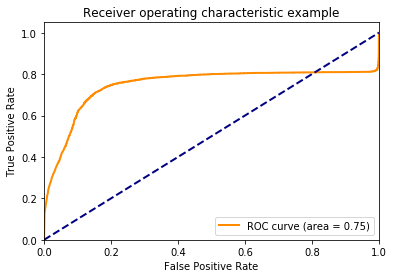

In [3]:
tf.reset_default_graph()
cont_data = mnist.MNISTContData(num_classes)
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, cont_data)
(fpr, tpr, roc_auc, pred) = mnist.run(mnistCont.withoutContingency, learning_rate, num_adversarial, cont_data, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

Training Accuracy in iteration  0 : 0.140625
Training Accuracy in iteration  50 : 0.984375
Training Accuracy in iteration  100 : 0.976562
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes: 0.989728
Final Accuracy on unexpected data: 0.179181
Final Accuracy on random data: 1.0


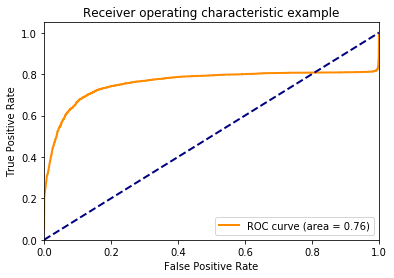

In [4]:
tf.reset_default_graph()
cont_data = mnist.MNISTContData(num_classes)
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, cont_data)
(fpr, tpr, roc_auc, pred) = mnist.run(mnistCont.withRandomContingency, learning_rate, num_adversarial, cont_data, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

In [8]:
from scipy import stats
stats.describe(cont_data.contingency_labels)

DescribeResult(nobs=2000, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)

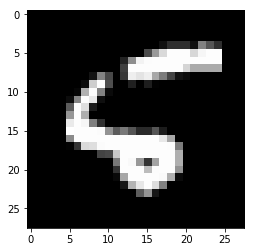

In [14]:
import matplotlib.pyplot as plt
plt.gray()
plt.imshow(cont_data.unexpected_data()[0][5].reshape([28, 28]))